## This notebook implements the MIAE method on the University of Houston RGB and Hyperspectral images

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
import os
from spectral import *
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun
import torch.utils.data as data
import torchsummary
import torchprofile
from fvcore.nn import FlopCountAnalysis, parameter_count_table

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Function to downsample an image by a given factor
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image

# Function to downsample an image to a reference shape
def downsample_to_shape(image, target_height, target_width):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Initialize a list to hold the resized channels
    resized_channels = []

    # Resize each channel individually
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        resized_channel = cv2.resize(channel, (target_width, target_height), interpolation=cv2.INTER_AREA)
        resized_channels.append(resized_channel)

    # Stack the resized channels back together
    resized_image = np.stack(resized_channels, axis=-1)

    return resized_image

# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

In [4]:
band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)

In [5]:
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [7]:
# Function to visualize an HSI
def visualize_hsi_single(img1, bands, title1):
    """
    Visualize a hyperspectral image using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation
    title1 : str
        Title for the first image.
    """
    rgb1 = get_rgb(img1, bands)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.imshow(rgb1)
    ax.set_title(title1)
    ax.axis('on')

    plt.tight_layout()
    plt.show()

Importing the University of Houston images

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Real_world_Fusion_based_HSI_Super_Resolution_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
hsi_1_file_path = os.path.join(normalized_dataset_path, 'hsi_1.mat')
hsi_2_file_path = os.path.join(normalized_dataset_path, 'hsi_2.mat')
rgb_1_file_path = os.path.join(normalized_dataset_path, 'rgb_image_1.tif')
rgb_2_file_path = os.path.join(normalized_dataset_path, 'rgb_image_2.tif')

In [9]:
def extract_aligned_patches(lr_hsi, hr_rgb, hsi_center_y, hsi_center_x,
                            hsi_patch_size=64, rgb_scale_factor=20, rgb_downsampled_size=512):
    """
    Extract a 64x64 patch from the LR HSI centered at (hsi_center_y, hsi_center_x),
    and the corresponding 1280x1280 patch from the HR RGB image centered at the
    scaled coordinates. Then downsample the RGB patch to 512x512.

    Parameters:
    -----------
    lr_hsi : np.ndarray
        Low-resolution HSI image of shape (H_lr, W_lr, C_hsi).
    hr_rgb : np.ndarray
        High-resolution RGB image of shape (H_hr, W_hr, 3).
    hsi_center_y : int
        Y-coordinate of the HSI patch center.
    hsi_center_x : int
        X-coordinate of the HSI patch center.
    hsi_patch_size : int
        Patch size for the HSI (default: 64).
    rgb_scale_factor : int
        Scaling factor between HSI and RGB resolutions (default: 20).
    rgb_downsampled_size : int
        Final size of the RGB patch after downsampling (default: 512).

    Returns:
    --------
    hsi_patch : np.ndarray
        Extracted HSI patch of shape (hsi_patch_size, hsi_patch_size, C_hsi).
    rgb_patch_downsampled : np.ndarray
        Downsampled RGB patch of shape (rgb_downsampled_size, rgb_downsampled_size, 3).
    """
    
    # --- HSI patch extraction ---
    half_hsi = hsi_patch_size // 2
    hsi_top = hsi_center_y - half_hsi
    hsi_left = hsi_center_x - half_hsi

    if (hsi_top < 0 or hsi_left < 0 or 
        hsi_top + hsi_patch_size > lr_hsi.shape[0] or 
        hsi_left + hsi_patch_size > lr_hsi.shape[1]):
        raise ValueError("HSI patch goes out of bounds.")

    hsi_patch = lr_hsi[
        hsi_top : hsi_top + hsi_patch_size,
        hsi_left : hsi_left + hsi_patch_size,
        :
    ]

    # --- RGB patch extraction ---
    rgb_patch_size = hsi_patch_size * rgb_scale_factor
    half_rgb = rgb_patch_size // 2
    rgb_center_y = hsi_center_y * rgb_scale_factor
    rgb_center_x = hsi_center_x * rgb_scale_factor
    rgb_top = rgb_center_y - half_rgb
    rgb_left = rgb_center_x - half_rgb

    if (rgb_top < 0 or rgb_left < 0 or 
        rgb_top + rgb_patch_size > hr_rgb.shape[0] or 
        rgb_left + rgb_patch_size > hr_rgb.shape[1]):
        raise ValueError("RGB patch goes out of bounds.")

    rgb_patch = hr_rgb[
        rgb_top : rgb_top + rgb_patch_size,
        rgb_left : rgb_left + rgb_patch_size,
        :
    ]

    # --- Downsample the RGB patch ---
    rgb_patch_downsampled = cv2.resize(
        rgb_patch,
        (rgb_downsampled_size, rgb_downsampled_size),
        interpolation=cv2.INTER_AREA
    )

    return hsi_patch, rgb_patch_downsampled

In [10]:
hsi_1 = sio.loadmat(hsi_1_file_path)
hsi_1_image = hsi_1['topLeft']

RGB_1 = cv2.imread(rgb_1_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_1_image = np.array(RGB_1)

hsi_patch_1, rgb_patch_1 = extract_aligned_patches(
    lr_hsi=hsi_1_image,
    hr_rgb=RGB_1_image,
    hsi_center_y=400,
    hsi_center_x=450
)

hsi_1_image = normalize(hsi_patch_1)
RGB_1_image = normalize(rgb_patch_1)

In [11]:
hsi_2 = sio.loadmat(hsi_2_file_path)
hsi_2_image = hsi_2['bottomRight']

RGB_2 = cv2.imread(rgb_2_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_2_image = np.array(RGB_2)

hsi_patch_2, rgb_patch_2 = extract_aligned_patches(
    lr_hsi=hsi_2_image,
    hr_rgb=RGB_2_image,
    hsi_center_y=400,
    hsi_center_x=400
)

hsi_2_image = normalize(hsi_patch_2)
RGB_2_image = normalize(rgb_patch_2)

Establishing training and inference images for the super resolution method

UH Hyperspectral image 1 inference shape:  (64, 64, 50)
UH Hyperspectral image 2 inference shape:  (64, 64, 50)


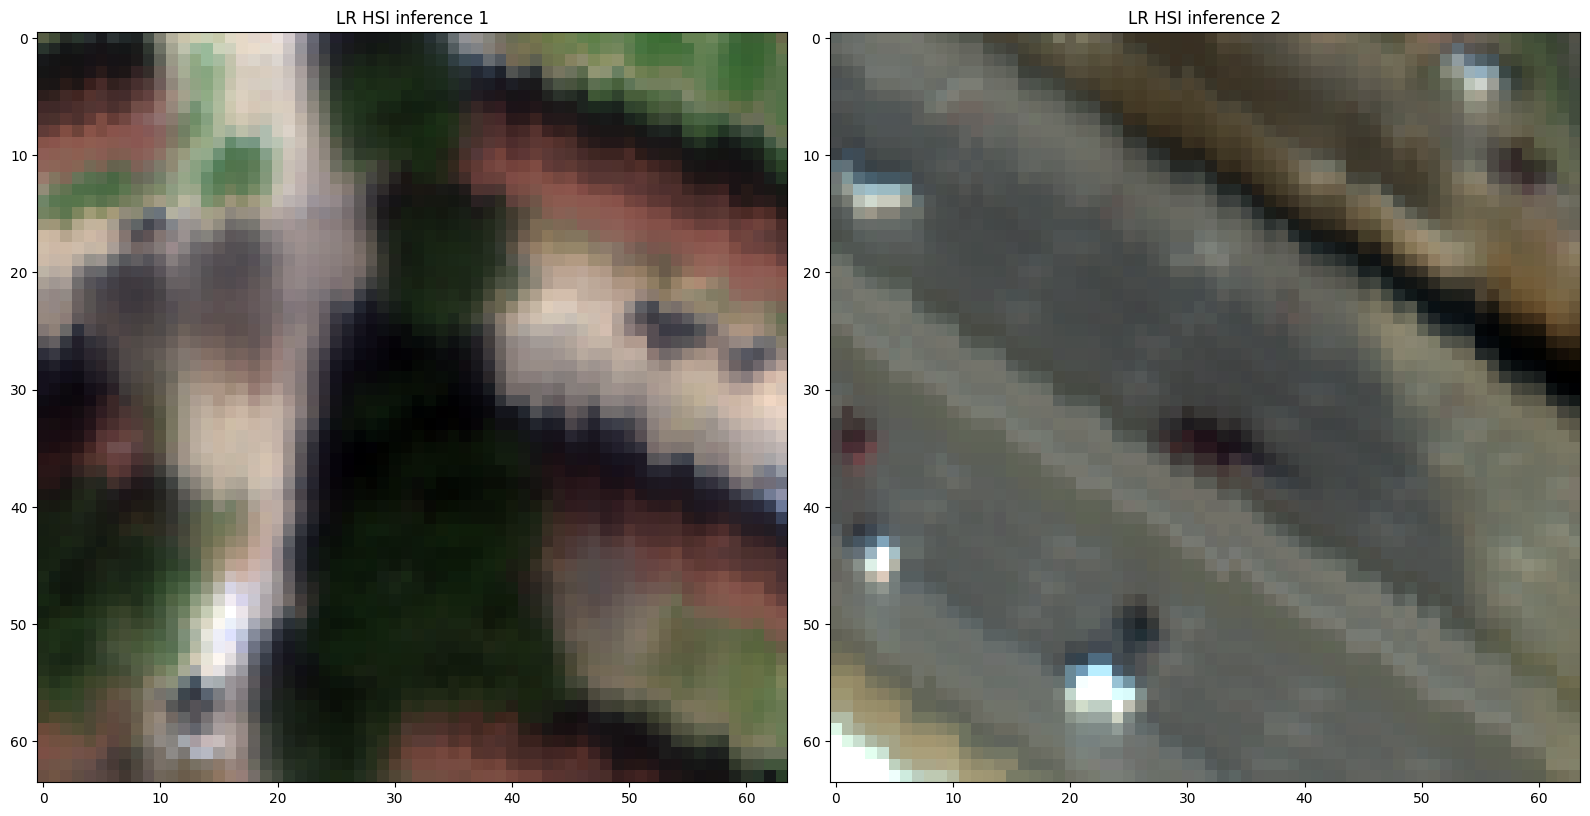

In [12]:
LR_HSI_test_1 = hsi_1_image
print("UH Hyperspectral image 1 inference shape: ", hsi_1_image.shape)

LR_HSI_test_2 = hsi_2_image
print("UH Hyperspectral image 2 inference shape: ", hsi_1_image.shape)

visualize_hsi(LR_HSI_test_1, LR_HSI_test_2, (20,13,8), "LR HSI inference 1", "LR HSI inference 2")

UH RGB image 1 inference shape:  (512, 512, 3)
UH RGB image 2 inference shape:  (512, 512, 3)


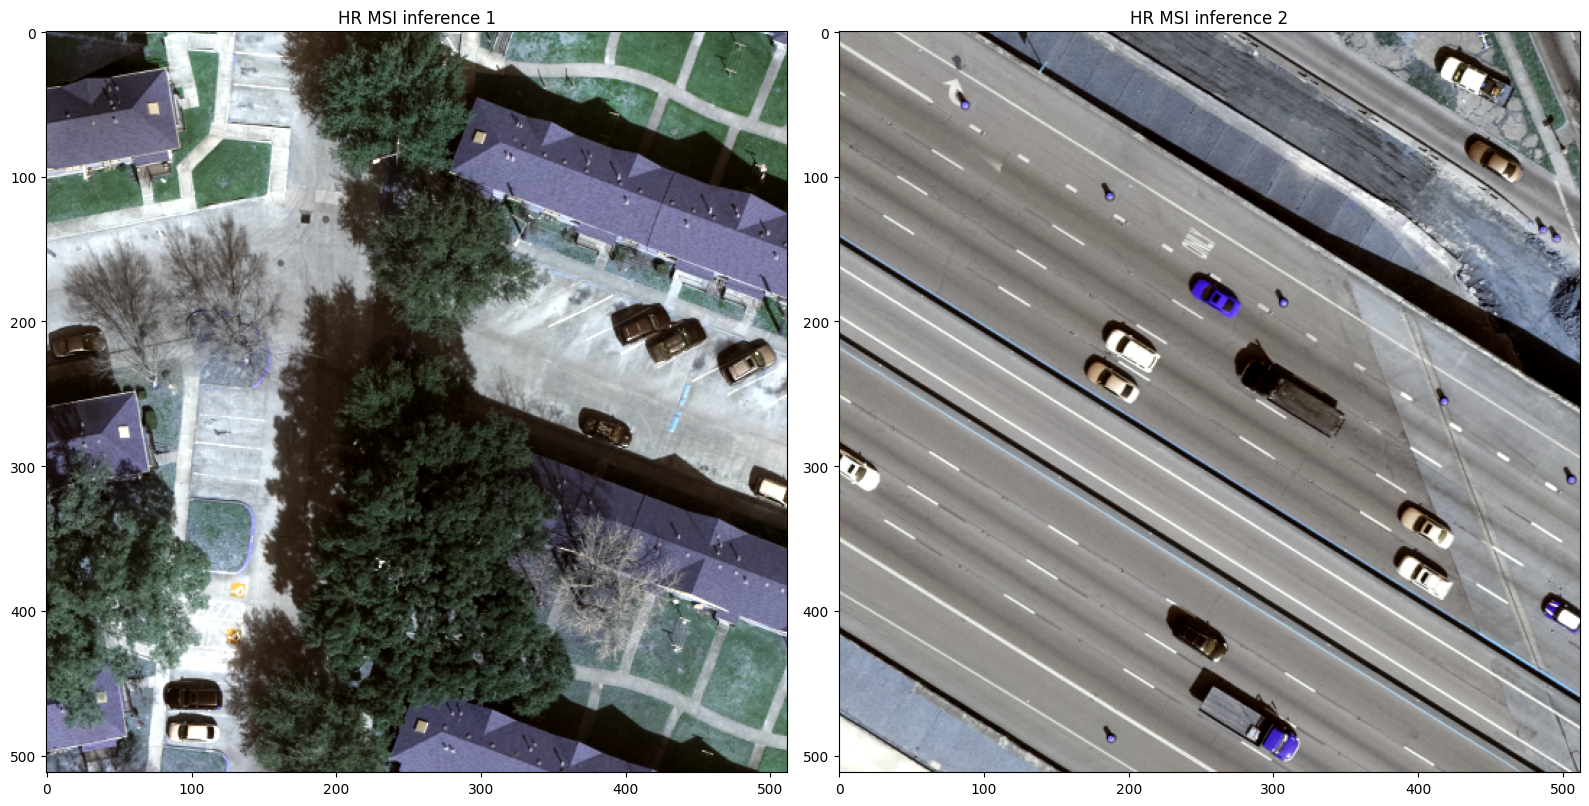

In [13]:
HR_MSI_test_1 = RGB_1_image
print("UH RGB image 1 inference shape: ", HR_MSI_test_1.shape)

HR_MSI_test_2 = RGB_2_image
print("UH RGB image 2 inference shape: ", HR_MSI_test_2.shape)

visualize_hsi(HR_MSI_test_1, HR_MSI_test_2, (0,1,2), "HR MSI inference 1", "HR MSI inference 2")

MIAE: Model Inspired Autoencoder for Unsupervised Hyperspectral Image Super-Resolution implementation from their GitHub

In [14]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [15]:
class BlurDown:
    def __init__(self, out_h, out_w, pad_mode='constant'):
        self.out_h = out_h
        self.out_w = out_w
        self.pad_mode = pad_mode  # 'constant', 'reflect', etc.

    def __call__(self, input_tensor: torch.Tensor, psf, pad, groups):
        """
        input_tensor: (N, C, H, W)
        psf:          (C, 1, kH, kW) or (1,1,kH,kW)
        pad:          integer for conv2d padding
        groups:       typically = C (each channel blurred individually)
        out_h, out_w: final desired spatial size
        """
        # 1) Repeat psf across channels if needed
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)

        # 2) Convolve with stride=1 => just blur
        blurred = fun.conv2d(input_tensor, psf, stride=1, padding=(pad, pad), groups=groups)

        # 3) Resize to (out_h, out_w). 
        out = fun.interpolate(blurred, size=(self.out_h, self.out_w), mode='bilinear')

        return out
    
class BlurDownBlind(object):
    def __init__(self, shift_h=0, shift_w=0, stride=0):
        self.shift_h = shift_h
        self.shift_w = shift_w
        self.stride = stride
        pass

    def __call__(self, input_tensor: torch.Tensor, psf, pad, groups, ratio):
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)
        if self.stride == 0:
            output_tensor = fun.conv2d(input_tensor, psf, None, (1, 1), (pad, pad), groups=groups)
            output_tensor = output_tensor[:, :, self.shift_h:: ratio, self.shift_h:: ratio]
        else:
            output_tensor = fun.conv2d(input_tensor, psf, None, (ratio, ratio), (pad, pad), groups=groups)
        return output_tensor
    
class torchkits(object):
    @staticmethod
    def extract_patches(input_tensor: torch.Tensor, kernel=3, stride=1, pad_num=0):
        # input_tensor: N x C x H x W, patches: N * H' * W', C, h, w
        if pad_num != 0:
            input_tensor = torch.nn.ReflectionPad2d(pad_num)(input_tensor)
        all_patches = input_tensor.unfold(2, kernel, stride).unfold(3, kernel, stride)
        N, C, H, W, h, w = all_patches.shape
        all_patches = all_patches.permute(0, 2, 3, 1, 4, 5)
        all_patches = torch.reshape(all_patches, shape=(N * H * W, C, h, w))
        return all_patches

    @staticmethod
    def torch_norm(input_tensor: torch.Tensor, mode=1):
        if mode == 1:
            loss = torch.sum(torch.abs(input_tensor))
            return loss
        return None
    
class PatchDataset(data.Dataset):
    # divide the images into several (overlapped) patches
    def __init__(self, hsi: torch.Tensor, msi: torch.Tensor, hsi_up: torch.Tensor, kernel, stride, ratio=1):
        super(PatchDataset, self).__init__()
        self.hsi = torchkits.extract_patches(hsi, kernel // ratio, stride // ratio, pad_num=0 // ratio)
        self.msi = torchkits.extract_patches(msi, kernel, stride, pad_num=0)
        self.hsi_up = torchkits.extract_patches(hsi_up, kernel, stride, pad_num=0)
        self.num = self.msi.shape[0]
        assert self.hsi.shape[0] == self.num

    def __getitem__(self, item):
        hsi = self.hsi[item, :, :, :]
        msi = self.msi[item, :, :, :]
        hsi_up = self.hsi_up[item, :, :, :]
        return hsi, msi, hsi_up, item

    def __len__(self):
        return self.num

In [16]:
class AENet(nn.Module):
    def __init__(self, hs_bands, ms_bands, edm_num, stage=3):
        super().__init__()
        self.hs_bands = hs_bands
        self.ms_bands = ms_bands
        self.edm_num = edm_num
        self.stage = stage
        self.module_list = nn.ModuleList([])
        edm = torch.ones([self.hs_bands, self.edm_num, 1, 1]) * (1.0 / self.edm_num)
        self.edm = nn.Parameter(edm)
        self.Y_net = nn.Sequential(
            nn.Conv2d(self.hs_bands, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.edm_num, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        self.Z_net = nn.Sequential(
            nn.Conv2d(self.ms_bands, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        self.S0_net = nn.Sequential(
            nn.Conv2d(2 * self.edm_num, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        for k in range(0, self.stage - 1):
            self.module_list.append(
                nn.Sequential(
                    nn.Conv2d(self.edm_num, self.edm_num, (1, 1)),
                    nn.LeakyReLU(0.2)
                )
            )
            self.module_list.append(
                nn.Sequential(
                    nn.Conv2d(3 * self.edm_num, self.edm_num, (1, 1)),
                    nn.LeakyReLU(0.2)
                )
            )
        self._init_weights(self)
        pass

    def forward(self, Yu, Z):
        N, B, H, W = Yu.shape
        N, b, H, W = Z.shape
        Y1 = self.Y_net(Yu)
        Z1 = self.Z_net(Z)
        S = torch.cat([Y1, Z1], dim=1)
        S = self.S0_net(S)
        for k in range(0, self.stage - 1):
            S = self.module_list[2 * k - 2](S)
            S = torch.cat([S, Y1, Z1], dim=1)
            S = self.module_list[2 * k - 1](S)
        S = torch.clamp(S, 0.0, 1.0)
        X = fun.conv2d(S, self.edm, None)
        X = torch.clamp(X, 0.0, 1.0)
        return X

    @staticmethod
    def _init_weights(model, init_type='normal'):
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                num_inputs = m.weight.data.shape[1]
                if init_type == 'normal':
                    nn.init.trunc_normal_(m.weight.data, mean=0.0, std=np.sqrt(1.0 / num_inputs))
                elif init_type == 'constant':
                    nn.init.constant_(m.weight.data, 1.0 / num_inputs)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)
        pass

In [17]:
class BlindNet(nn.Module):
    def __init__(self, hs_bands, ms_bands, ker_size, ratio):
        super().__init__()
        self.hs_bands = hs_bands
        self.ms_bands = ms_bands
        self.ker_size = ker_size
        self.ratio = ratio
        self.pad_num = int((self.ker_size - 1) / 2)
        
        psf = torch.ones([1, 1, self.ker_size, self.ker_size]) * (1.0 / (self.ker_size ** 2))
        self.psf = nn.Parameter(psf)
        
        srf = torch.ones([self.ms_bands, self.hs_bands, 1, 1]) * (1.0 / self.hs_bands)
        self.srf = nn.Parameter(srf)
        
        self.blur_down = BlurDownBlind(stride=0) 

    def forward(self, Y, Z):
        srf_div = torch.sum(self.srf, dim=1, keepdim=True)
        srf_div = torch.div(1.0, srf_div)
        srf_div = torch.transpose(srf_div, 0, 1)  # 1 x l x 1 x 1

        Ylow = fun.conv2d(Y, self.srf, None)
        Ylow = torch.mul(Ylow, srf_div)
        Ylow = torch.clamp(Ylow, 0.0, 1.0)

        Zlow = self.blur_down(Z, self.psf, self.pad_num, self.ms_bands, self.ratio)
        Zlow = torch.clamp(Zlow, 0.0, 1.0)

        return Ylow, Zlow

    def check_weight(model):
        if hasattr(model, 'psf'):
            w = model.psf.data
            w.clamp_(0.0, 1.0)
            psf_div = torch.sum(w)
            psf_div = torch.div(1.0, psf_div)
            w.mul_(psf_div)
        if hasattr(model, 'srf'):
            w = model.srf.data
            w.clamp_(0.0, 10.0)
            srf_div = torch.sum(w, dim=1, keepdim=True)
            srf_div = torch.div(1.0, srf_div)
            w.mul_(srf_div)

    
def train_blindnet(LR_LR_HSI, LR_MSI, ratio=8, max_iter=5000, verbose=True):
    hs_bands = LR_LR_HSI.shape[1]
    ms_bands = LR_MSI.shape[1]
    ker_size = 2 * ratio - 1
    out_h = LR_LR_HSI.shape[2]  # h
    out_w = LR_LR_HSI.shape[3]  # w

    model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-6)

    LR_LR_HSI = LR_LR_HSI.to(device)
    LR_MSI = LR_MSI.to(device)

    pbar = tqdm(range(max_iter), desc="Blind PSF/SRF Estimation", dynamic_ncols=True, ncols=80, leave=True)
    for epoch in pbar:
        model.train()
        Ylow, Zlow = model(LR_LR_HSI, LR_MSI)
        loss = torch.sum(torch.abs(Ylow - Zlow))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.check_weight()

        pbar.set_postfix(loss=f"{loss.item():.6f}")

    pbar.close()

    psf_est = model.psf.detach().cpu().numpy().squeeze()
    srf_est = model.srf.detach().cpu().numpy().squeeze()
    return psf_est, srf_est

In [18]:
class MIAE:
    def __init__(
        self,
        I_HS: np.ndarray,
        I_MS: np.ndarray,
        I_REF: np.ndarray,
        psf: np.ndarray,
        srf: np.ndarray,
        ratio=8,
        edm_num=80,
        stage=3,
        patch_size_hr=32,    
        patch_stride_hr=32   
    ):
        """
        I_HS: low-res HSI (h, w, L)
        I_MS: MSI (H, W, l)
        I_REF: GT HSI (H, W, L) or None
        psf: (K,K)
        srf: (l,L)
        """
        I_HS = I_HS.astype(np.float32)
        I_MS = I_MS.astype(np.float32)
        self.ref = I_REF.astype(np.float32) if I_REF is not None else None

        # Shapes
        self.h, self.w, self.hs_bands = I_HS.shape
        self.H, self.W, self.ms_bands = I_MS.shape
        self.ratio = ratio

        # Convert to Torch
        self.hsi = torch.from_numpy(np.transpose(I_HS, (2,0,1))[None, ...])
        self.msi = torch.from_numpy(np.transpose(I_MS, (2,0,1))[None, ...])

        # Upsample HSI to MSI resolution
        self.__hsi_up = nn.Upsample(size=(self.H, self.W), mode='bilinear', align_corners=False)(self.hsi)

        # PSF (L,1,K,K)
        self.ker_size = psf.shape[0]
        self.psf = torch.tensor(psf[np.newaxis, np.newaxis, ...].astype(np.float32))
        self.psf_hs = self.psf.repeat(self.hs_bands, 1, 1, 1)

        # SRF (l,L,1,1)
        self.srf = torch.tensor(srf[:, :, np.newaxis, np.newaxis].astype(np.float32))

        # Model
        self.model = AENet(self.hs_bands, self.ms_bands, edm_num, stage)

        # Move everything to device
        self.__hsi = self.hsi.float().to(device)
        self.__msi = self.msi.float().to(device)
        self.__hsi_up = self.__hsi_up.float().to(device)
        self.psf_hs = self.psf_hs.to(device)
        self.srf = self.srf.to(device)
        self.model = self.model.to(device)

        # Optimizer
        self.lr = 0.005
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-3)
        self.lr_fun = lambda epoch: (1.0 - max(0, epoch + 1 - 1000) / 9000)
        self.scheduler = optim.lr_scheduler.LambdaLR(self.optimizer, self.lr_fun)

        # Patch training settings
        # Patch training parameters (user-controlled)
        self.patch_size   = patch_size_hr      # HR MSI patch size (e.g., 32)
        self.patch_stride = patch_stride_hr    # HR MSI stride (e.g., 32)
        self.batch_size   = self.set_batch_size()

        # Border removal
        self.hs_border = math.ceil((self.ker_size - 1) / 2 / self.ratio)
        self.ms_border = self.hs_border * self.ratio

        # Blur object
        self.blur_down = BlurDown(out_h=self.h, out_w=self.w)

        # Dataset
        self.dataset = PatchDataset(
            self.__hsi,
            self.__msi,
            self.__hsi_up,
            kernel=self.patch_size,
            stride=self.patch_stride,
            ratio=self.ratio
        )
        self.loader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def set_batch_size(self):
        return 32

    def cpt_target(self, X, hsi_patch_shape=None):
        """
        Spatial degrade: blur + downsample => Y
        Spectral degrade: conv with srf => Z
        """
        pad = int((self.ker_size - 1) / 2)
        if hsi_patch_shape is None:
            # Default: full-size
            out_h, out_w = self.h, self.w
        else:
            out_h, out_w = hsi_patch_shape[-2], hsi_patch_shape[-1]

        # Build patch-specific BlurDown
        blur_down_patch = BlurDown(out_h=out_h, out_w=out_w)

        # Apply blur down
        Y = blur_down_patch(
            input_tensor=X,
            psf=self.psf_hs,
            pad=pad,
            groups=self.hs_bands
        )

        Z = fun.conv2d(X, self.srf, None)
        return Y, Z

    def build_loss(self, Y, Z, hsi, msi):
        dY = Y - hsi
        dZ = Z - msi

        dY = dY[:, :, self.hs_border:-self.hs_border, self.hs_border:-self.hs_border]
        dZ = dZ[:, :, self.ms_border:-self.ms_border, self.ms_border:-self.ms_border]

        # Patch sizes instead of full image
        patch_H = msi.shape[-2]
        patch_W = msi.shape[-1]

        loss_spatial = torch.sum(torch.mean(torch.abs(dY), dim=(2,3))) * ((patch_H/self.ratio)*(patch_W/self.ratio))
        loss_spectral = torch.sum(torch.mean(torch.abs(dZ), dim=(2,3))) * (patch_H*patch_W)
        return loss_spatial + loss_spectral

    def train(self, max_iter=10000, verb=True):
        self.model.train()
        iteration = 0
        recent_losses = deque(maxlen=50)

        pbar = tqdm(total=max_iter, desc="Patch-based Training", dynamic_ncols=True, ncols=100)  # <<< Create pbar ONCE!

        while iteration < max_iter:
            for hsi, msi, hsi_up, _ in self.loader:
                hsi, msi, hsi_up = hsi.to(device), msi.to(device), hsi_up.to(device)

                X = self.model(hsi_up, msi)
                Yhat, Zhat = self.cpt_target(X, hsi_patch_shape=hsi.shape)
                loss = self.build_loss(Yhat, Zhat, hsi, msi)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.model.edm.data.clamp_(0.0, 1.0)

                iteration += 1
                recent_losses.append(loss.item())

                # Update the single tqdm bar
                pbar.update(1)
                pbar.set_postfix(loss=f"{sum(recent_losses)/len(recent_losses):.4f}")

                if iteration >= max_iter:
                    break

            self.scheduler.step()

        pbar.close()

    def get_super_resolved(self):
        """
        Final super-resolved HSI + metrics (parameters, FLOPs, GPU memory, time) 
        using patch-based inference (same as training patching).
        """
        self.model.eval()

        # Number of parameters (no patch dependency)
        num_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        # FLOPs for a single patch
        sample_hsi, sample_msi, sample_hsi_up, _ = self.dataset[0]
        sample_hsi_up = sample_hsi_up.unsqueeze(0).to(device)
        sample_msi    = sample_msi.unsqueeze(0).to(device)

        try:
            flops_per_patch, param_table = get_flops_fvcore(self.model, (sample_hsi_up, sample_msi))
        except:
            flops_per_patch = None

        # Prepare full-sized output tensor
        _, L, H, W = self.__hsi_up.shape
        pred_full = torch.zeros((1, L, H, W), device=device)

        # Calculate patch grid
        patch_size   = self.patch_size
        patch_stride = self.patch_stride
        H_patches = (H - patch_size) // patch_stride + 1
        W_patches = (W - patch_size) // patch_stride + 1
        total_patches = H_patches * W_patches

        # GPU memory and inference time tracking
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        _ = torch.cuda.max_memory_allocated(device)

        start_time = time.time()

        # Patchwise inference with tqdm
        pbar = tqdm(total=total_patches, desc="Patch-based Inference", ncols=100)
        patch_idx = 0
        for i in range(0, H - patch_size + 1, patch_stride):
            for j in range(0, W - patch_size + 1, patch_stride):
                # Extract patch
                hsi_patch = self.__hsi_up[..., i:i+patch_size, j:j+patch_size]
                msi_patch = self.__msi[..., i:i+patch_size, j:j+patch_size]

                with torch.no_grad():
                    pred_patch = self.model(hsi_patch, msi_patch)

                # Insert back into full prediction
                pred_full[..., i:i+patch_size, j:j+patch_size] = pred_patch

                patch_idx += 1
                pbar.update(1)

        end_time = time.time()
        pbar.close()

        max_mem = torch.cuda.max_memory_allocated(device)
        inference_time = end_time - start_time

        # FLOPs over all patches
        total_flops = flops_per_patch * total_patches if flops_per_patch is not None else None

        # Convert output (1, L, H, W) -> (H, W, L)
        X_np = pred_full.squeeze(0).permute(1,2,0).cpu().numpy()

        # Print metrics
        print(f"Number of parameters: {num_params}")
        if total_flops is not None:
            print(f"FLOPs: {total_flops}")
        else:
            print(f"FLOPs: not computed (fvcore issue)")
        print(f"Peak GPU memory: {max_mem / (1024 ** 2):.2f} MB")
        print(f"Inference time: {inference_time:.4f} seconds")

        return X_np

In [19]:
def plot_psf_srf(psf_est, srf_est):
    """
    Plot PSF as heatmap and SRF as curves.

    Args:
        psf_est: (kH, kW) numpy array
        srf_est: (ms_bands, hs_bands) numpy array
    """
    ms_bands, hs_bands = srf_est.shape

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot PSF ---
    ax = axs[0]
    im = ax.imshow(psf_est, cmap='viridis')
    ax.set_title('Estimated PSF')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # --- Plot SRF ---
    ax = axs[1]
    x = np.arange(hs_bands)
    for i in range(ms_bands):
        ax.plot(x, srf_est[i], label=f'MSI Band {i+1}')
    ax.set_title('Estimated SRF (Spectral Curves)')
    ax.set_xlabel('HSI Band Index')
    ax.set_ylabel('Relative Response')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

In [20]:
def extract_patch_at_coordinates(image, top_y, left_x, patch_size=16):
    """
    Extract a patch of size patch_size x patch_size starting at (top_y, left_x).

    Args:
        image (np.ndarray): Image of shape (H, W, C).
        top_y (int): Y-coordinate (row) of the top-left corner of the patch.
        left_x (int): X-coordinate (column) of the top-left corner of the patch.
        patch_size (int): Size of the patch (default: 16).

    Returns:
        patch (np.ndarray): Extracted patch of shape (patch_size, patch_size, C).
    """
    # Bounds check
    if (top_y < 0 or left_x < 0 or
        top_y + patch_size > image.shape[0] or
        left_x + patch_size > image.shape[1]):
        raise ValueError("Patch goes out of image bounds.")

    return image[top_y : top_y + patch_size, left_x : left_x + patch_size, :]

Output file to save super-resolved images

In [21]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/MIAE"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
uh_miae_folder_path = os.path.join(normalized_target_path, 'University_of_Houston')

# Create the folder if it doesn't exist
if not os.path.exists(uh_miae_folder_path):
    os.makedirs(uh_miae_folder_path)

Super resolving UH image 1 

Unsupported operator aten::sum encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::mul encountered 1 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


Total parameters in blind model: 375
Total FLOPs (1× forward): 177,561,600


Blind PSF/SRF Estimation:   0%|          | 0/5000 [00:00<?, ?it/s]

Blind training took 15.1s
Peak GPU memory during training: 13.8 MB


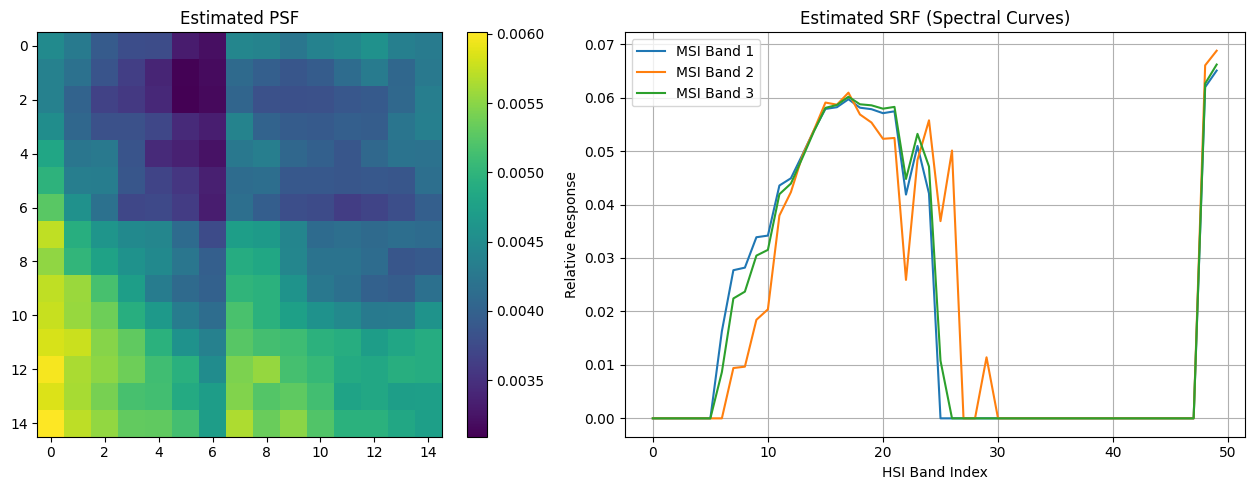

In [22]:
ratio = 8

# 1) Figure out your shapes & bands
H_lr, W_lr, hs_bands = LR_HSI_test_1.shape
H_hr, W_hr, ms_bands = HR_MSI_test_1.shape
ker_size = 2 * ratio - 1  # whatever ratio you chose

# 2) Build input tensors
LR_HSI_tensor = (
    torch.from_numpy(LR_HSI_test_1)
         .permute(2,0,1)          # (C_hsi, H_lr, W_lr)
         .unsqueeze(0)            # (1, C_hsi, H_lr, W_lr)
         .float()
         .to(device)
)
HR_MSI_tensor = (
    torch.from_numpy(HR_MSI_test_1)
         .permute(2,0,1)          # (C_msi, H_hr, W_hr)
         .unsqueeze(0)            # (1, C_msi, H_hr, W_hr)
         .float()
         .to(device)
)

# 3) Instantiate and eval
blind_model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
blind_model.eval()

# 4) Count params
total_params_blind = sum(
    p.numel() for p in blind_model.parameters() if p.requires_grad
)
print(f"Total parameters in blind model: {total_params_blind:,}")

# 5) Compute FLOPs for one forward
#    Use the same shapes actually fed in:
dummy_Y = torch.randn(1, hs_bands, H_lr, W_lr, device=device)
dummy_Z = torch.randn(1, ms_bands, H_hr, W_hr, device=device)
flops_blind = FlopCountAnalysis(blind_model, (dummy_Y, dummy_Z)).total()
print(f"Total FLOPs (1× forward): {flops_blind:,}")

# 6) Measure peak GPU memory during training
torch.cuda.reset_peak_memory_stats(device)
start_time = time.time()

# run blind training (this will internally step and clamp)
psf_est, srf_est = train_blindnet(
    LR_HSI_tensor,
    HR_MSI_tensor,
    ratio=ratio,
    max_iter=5000
)

peak_bytes = torch.cuda.max_memory_allocated(device)
peak_mb    = peak_bytes / 1024**2

end_time = time.time()
print(f"Blind training took {end_time - start_time:.1f}s")
print(f"Peak GPU memory during training: {peak_mb:.1f} MB")

# 7) Finally, plot the estimated PSF and SRF
plot_psf_srf(psf_est, srf_est)

In [23]:
ratio = 8
stage = 3
edm_num = 20
_, srf, wavelengths = apply_srf(LR_HSI_test_1, band_specs, fwhm_factor=4.2)

# Create the MIAE object
net = MIAE(
    I_HS=LR_HSI_test_1,
    I_MS=HR_MSI_test_1,
    I_REF=None,  # or None
    psf=psf_est,
    srf=srf,    # The blind estimation for the SRF is bad and does not correspond to an RGB sensor well so we use the IKONOS SRF as an approximation
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Time the training
start_time = time.time()

# Train 
net.train(max_iter=50000, verb=True)

end_time = time.time()
# Print the training time
training_time = end_time - start_time
print(f"Training done in {training_time:.2f}s")

# Then, after training is done, obtain final super-resolved image:
SR_image_1 = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy
print("SR image shape: ", SR_image_1.shape)

print("SR image max:", SR_image_1.max())
print("SR image min:", SR_image_1.min())
print("SR image mean:", SR_image_1.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_miae_folder_path}/UH_topleft.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_1)

print("Saved Super Resolved HSI 1 at location specified in uh_miae_folder_path")

Patch-based Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Unsupported operator aten::leaky_relu encountered 8 time(s)


Training done in 193.93s


Patch-based Inference:   0%|                                                | 0/256 [00:00<?, ?it/s]

Number of parameters: 6620
FLOPs: 1693450240
Peak GPU memory: 166.12 MB
Inference time: 0.0955 seconds
SR image shape:  (512, 512, 50)
SR image max: 1.0
SR image min: 0.0
SR image mean: 0.3793351
Saved Super Resolved HSI 1 at location specified in uh_miae_folder_path


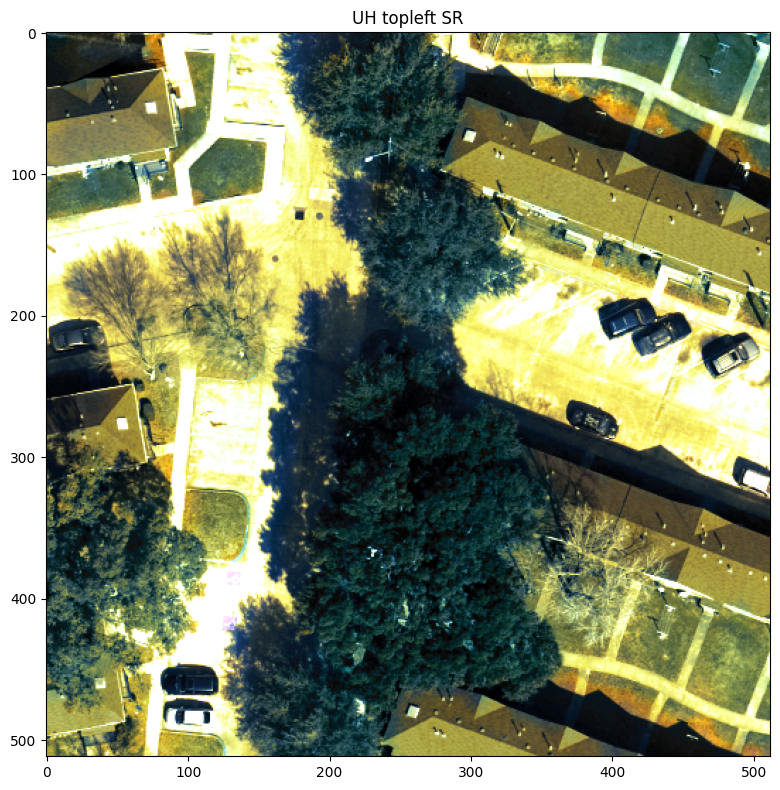

In [24]:
visualize_hsi_single(SR_image_1, (20,13,8), "UH topleft SR")

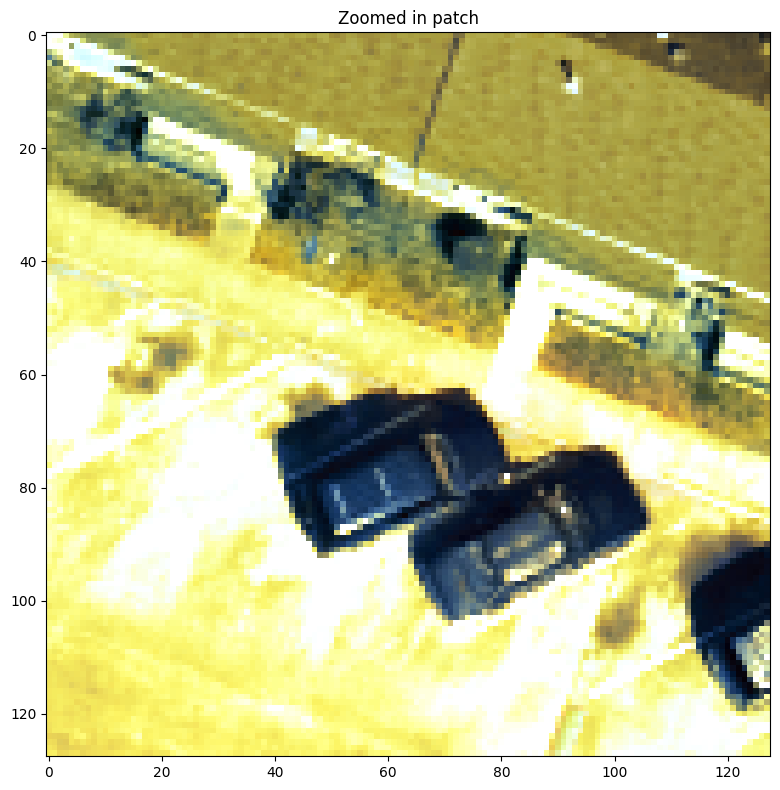

In [25]:
patch = extract_patch_at_coordinates(SR_image_1, 125, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")

Super resolving UH image 2

Unsupported operator aten::sum encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::mul encountered 1 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


Total parameters in blind model: 375
Total FLOPs (1× forward): 177,561,600


Blind PSF/SRF Estimation:   0%|          | 0/5000 [00:00<?, ?it/s]

Blind training took 13.6s
Peak GPU memory during training: 121.5 MB


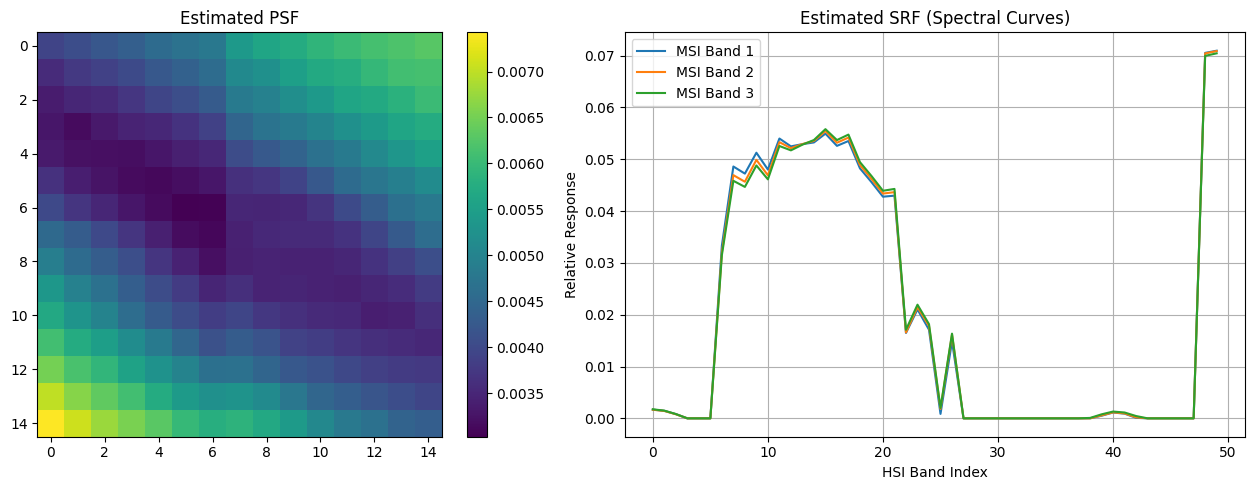

In [26]:
ratio = 8

# 1) Figure out your shapes & bands
H_lr, W_lr, hs_bands = LR_HSI_test_2.shape
H_hr, W_hr, ms_bands = HR_MSI_test_2.shape
ker_size = 2 * ratio - 1  # whatever ratio you chose

# 2) Build input tensors
LR_HSI_tensor = (
    torch.from_numpy(LR_HSI_test_2)
         .permute(2,0,1)          # (C_hsi, H_lr, W_lr)
         .unsqueeze(0)            # (1, C_hsi, H_lr, W_lr)
         .float()
         .to(device)
)
HR_MSI_tensor = (
    torch.from_numpy(HR_MSI_test_2)
         .permute(2,0,1)          # (C_msi, H_hr, W_hr)
         .unsqueeze(0)            # (1, C_msi, H_hr, W_hr)
         .float()
         .to(device)
)

# 3) Instantiate and eval
blind_model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
blind_model.eval()

# 4) Count params
total_params_blind = sum(
    p.numel() for p in blind_model.parameters() if p.requires_grad
)
print(f"Total parameters in blind model: {total_params_blind:,}")

# 5) Compute FLOPs for one forward
#    Use the same shapes actually fed in:
dummy_Y = torch.randn(1, hs_bands, H_lr, W_lr, device=device)
dummy_Z = torch.randn(1, ms_bands, H_hr, W_hr, device=device)
flops_blind = FlopCountAnalysis(blind_model, (dummy_Y, dummy_Z)).total()
print(f"Total FLOPs (1× forward): {flops_blind:,}")

# 6) Measure peak GPU memory during training
torch.cuda.reset_peak_memory_stats(device)
start_time = time.time()

# run blind training (this will internally step and clamp)
psf_est, srf_est = train_blindnet(
    LR_HSI_tensor,
    HR_MSI_tensor,
    ratio=ratio,
    max_iter=5000
)

peak_bytes = torch.cuda.max_memory_allocated(device)
peak_mb    = peak_bytes / 1024**2

end_time = time.time()
print(f"Blind training took {end_time - start_time:.1f}s")
print(f"Peak GPU memory during training: {peak_mb:.1f} MB")

# 7) Finally, plot the estimated PSF and SRF
plot_psf_srf(psf_est, srf_est)

In [27]:
ratio = 8
stage = 3
edm_num = 20
_, srf, wavelengths = apply_srf(LR_HSI_test_2, band_specs, fwhm_factor=4.2)

# Create the MIAE object
net = MIAE(
    I_HS=LR_HSI_test_2,
    I_MS=HR_MSI_test_2,
    I_REF=None,  # or None
    psf=psf_est,
    srf=srf,    # The blind estimation for the SRF is bad and does not correspond to an RGB sensor well so we use the IKONOS SRF as an approximation
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Time the training
start_time = time.time()

# Train 
net.train(max_iter=50000, verb=True)

end_time = time.time()
# Print the training time
training_time = end_time - start_time
print(f"Training done in {training_time:.2f}s")

# Then, after training is done, obtain final super-resolved image:
SR_image_2 = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy
print("SR image shape: ", SR_image_2.shape)

print("SR image max:", SR_image_2.max())
print("SR image min:", SR_image_2.min())
print("SR image mean:", SR_image_2.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_miae_folder_path}/UH_bottomright.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_2)

print("Saved Super Resolved HSI 2 at location specified in uh_miae_folder_path")

Patch-based Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Unsupported operator aten::leaky_relu encountered 8 time(s)


Training done in 193.83s


Patch-based Inference:   0%|                                                | 0/256 [00:00<?, ?it/s]

Number of parameters: 6620
FLOPs: 1693450240
Peak GPU memory: 166.12 MB
Inference time: 0.0943 seconds
SR image shape:  (512, 512, 50)
SR image max: 1.0
SR image min: 0.0
SR image mean: 0.47964036
Saved Super Resolved HSI 2 at location specified in uh_miae_folder_path


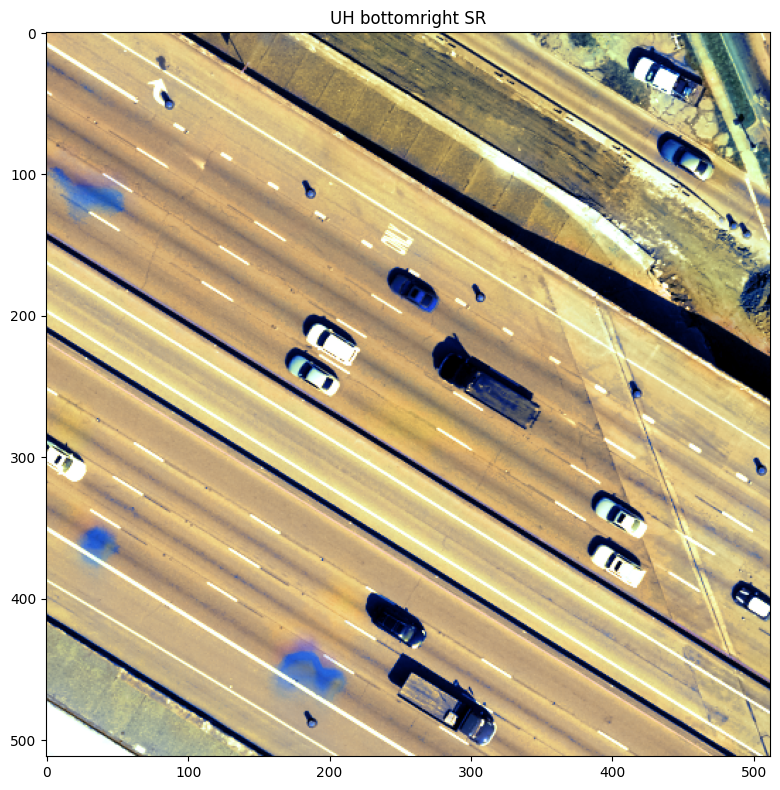

In [28]:
visualize_hsi_single(SR_image_2, (20,13,8), "UH bottomright SR")

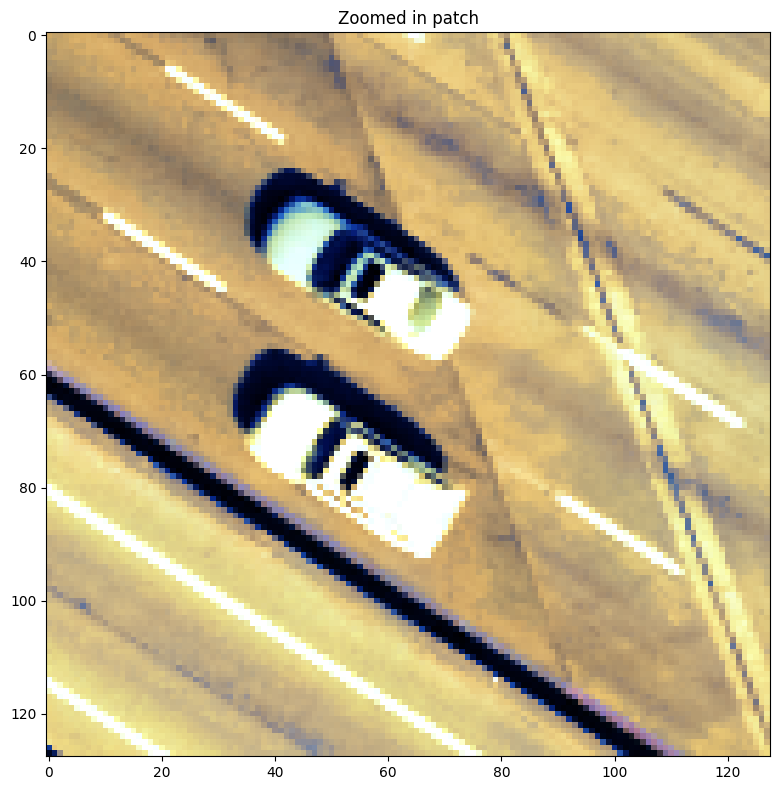

In [29]:
patch = extract_patch_at_coordinates(SR_image_2, 300, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")